# Exercise: TKO_3120 Machine Learning and Pattern Recognition

Student: Tomi Salomaa
<br/>Number: 
<br/>Date: 8/3/2021

# The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order. The goal of this execrisce, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

# Import Packages
Import all the packages needed for this notebook in one cell

In [14]:
import numpy as np
import os
import platform
import cv2
import random
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from sklearn import datasets, metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from google.colab import files

# Load the raw CIFAR-10 data

Donwnload the dataset from the zip file (cifar-10-batches-py) in moodle. Then unzip the file. 

In [15]:
# Uploading exercise files to google colab platform
# Uncomment the files.upload if ran fresh on google colab.
# required files within the cifar10 directory are:
# batches.meta
  # data_batch_1
  # data_batch_2
  # data_batch_3
  # data_batch_4
  # data_batch_5
  # test_batch
# place the directory in root

# uploaded = files.upload()

In [16]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [17]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [18]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

In [19]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar10'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Data Visualization

Show a few examples of training images from each class.

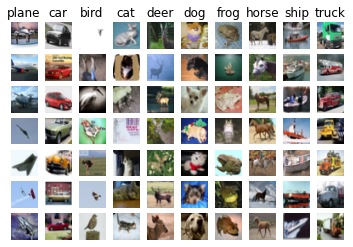

In [20]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Feature extraction



## 1- Color Mean and Standard Deviation
**Question (1 point):** 
Calculate the below mentioned color features for each image:

- Mean for each RGB color channel
- Standard Deviation (STD) for each RGB color channel


In [21]:
# Arrays to hold training data means and standard variations
X_train_img_mean_color_channels = []
X_train_img_std_color_channels = []
# Arrays to hold test data means and standard variations
X_test_img_mean_color_channels = []
X_test_img_std_color_channels = []

# For both the mean and standard arrays the data will be saved in the following example order:
# [ [[red_axis0],[red_axis1]], [[green_axis0],[green_axis1]], [[blue_axis0],[blue_axis1]] ]

# Iterate through the X_train contents and capture RGB values from each image.
# Calculate the means and standard deviations, append to the X_train_img arrays above.
for i in range(len(X_train)):
  r = X_train[i][:,:,0]
  g = X_train[i][:,:,1]
  b = X_train[i][:,:,2]
  X_train_img_mean_color_channels.append([[np.mean(r,axis=0),np.mean(r,axis=1)],
                                          [np.mean(g,axis=0),np.mean(g,axis=1)],
                                          [np.mean(b,axis=0),np.mean(b,axis=1)]])
  X_train_img_std_color_channels.append([[np.std(r,axis=0),np.std(r,axis=1)],
                                          [np.std(g,axis=0),np.std(g,axis=1)],
                                          [np.std(b,axis=0),np.std(b,axis=1)]])

# Do the same for test images.
for i in range(len(X_test)):
  r = X_test[i][:,:,0]
  g = X_test[i][:,:,1]
  b = X_test[i][:,:,2]
  X_test_img_mean_color_channels.append([[np.mean(r,axis=0),np.mean(r,axis=1)],
                                          [np.mean(g,axis=0),np.mean(g,axis=1)],
                                          [np.mean(b,axis=0),np.mean(b,axis=1)]])
  X_test_img_std_color_channels.append([[np.std(r,axis=0),np.std(r,axis=1)],
                                          [np.std(g,axis=0),np.std(g,axis=1)],
                                          [np.std(b,axis=0),np.std(b,axis=1)]])

# Convert from python list to numpy arrays. Do not know if this matters, but
# have had problems with mixed array / list / dataframe variables in the past
# so attempting to keep everything as numpy as possible. Computing resources
# probably allow for this in this exercise.
X_train_img_mean_color_channels = np.asarray(X_train_img_mean_color_channels)
X_train_img_std_color_channels = np.asarray(X_train_img_std_color_channels)
X_test_img_mean_color_channels = np.asarray(X_test_img_mean_color_channels)
X_test_img_std_color_channels = np.asarray(X_test_img_std_color_channels)

# Checking the arrays after adding contents. Array lengths should be
# 50 000 for training and 10 000 for testing.
print('X_train shape:',X_train.shape)
print('X_train_img_mean_color_channels shape:',X_train_img_mean_color_channels.shape)
print('X_test shape:',X_test.shape)
print('X_test_img_mean_color_channels shape:',X_test_img_mean_color_channels.shape)

X_train shape: (50000, 32, 32, 3)
X_train_img_mean_color_channels shape: (50000, 3, 2, 32)
X_test shape: (10000, 32, 32, 3)
X_test_img_mean_color_channels shape: (10000, 3, 2, 32)


## 2- Color Histograms
**Question (1 point):**

   Obtain histogram feature  (e.g. cv2.calcHist from OpenCV) for each of RGB channel with 8 bins per channel. 

In [22]:
# Arrays to store the histogram values
X_train_rgb_histograms = []
X_test_rgb_histograms = []

# Iterate over X_train and capture RGB values for histogram.
# cv2.calcHist is used, affects the order RGB => BGR.
for i in range(len(X_train)):
  rgb_chan_train = []
  for j, col in enumerate(['b','g','r']):
    hist = cv2.calcHist([X_train[i].astype('uint8')],[j],None,[8],[0,256])
    rgb_chan_train.append(hist)
  X_train_rgb_histograms.append(np.asarray(rgb_chan_train))
# Convert to numpy array
X_train_rgb_histograms = np.asarray(X_train_rgb_histograms)

# Same for test images.
for i in range(len(X_test)):  
  rgb_chan_test = []
  for j, col in enumerate(['b','g','r']):
    hist = cv2.calcHist([X_test[i].astype('uint8')],[j],None,[8],[0,256])
    rgb_chan_test.append(hist)
  X_test_rgb_histograms.append(np.asarray(rgb_chan_test))
X_test_rgb_histograms = np.asarray(X_test_rgb_histograms)

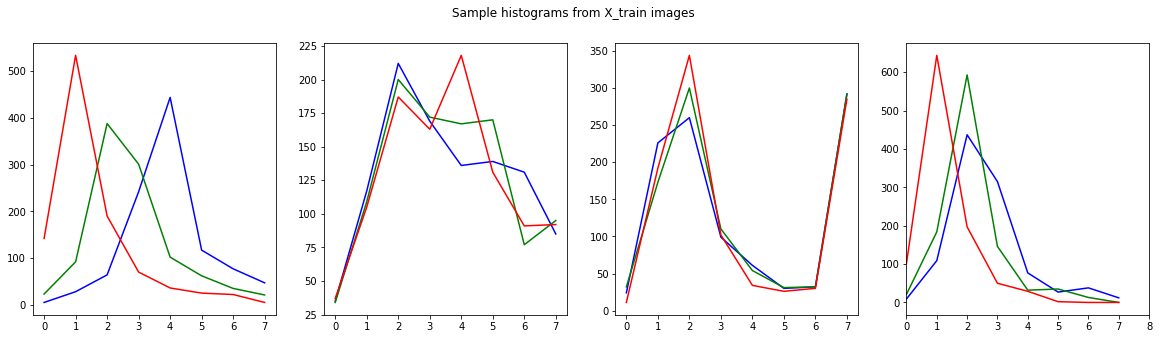

In [23]:
# Plotting a sample from train array to check contents
fig, axs = plt.subplots(nrows=1,ncols=4)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Sample histograms from X_train images')
for i in range(4):
  for j, col in enumerate(['b','g','r']):
    axs[i].plot(X_train_rgb_histograms[i][j],color=col)
plt.xlim([0,8])
plt.tight_layout
plt.show()

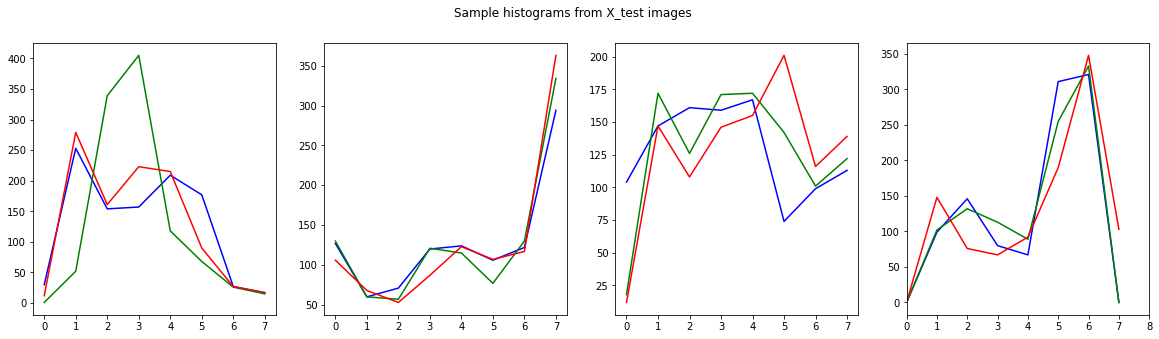

In [24]:
# Plotting a sample from test array to check contents
fig, axs = plt.subplots(nrows=1,ncols=4)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Sample histograms from X_test images')
for i in range(4):
  for j, col in enumerate(['b','g','r']):
    axs[i].plot(X_test_rgb_histograms[i][j],color=col)
plt.xlim([0,8])
plt.tight_layout
plt.show()

## 3- Local Binary Patterns (LBP)
**Question (1 point):**
Create Local Binary Pattern of each image 

    

In [25]:
# Convert to grayscale.
# Weights are from https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems.
def rgb_to_gray(image):
  image_copy = image.astype(float)
  grayscale = image_copy[:,:,0]*0.299+image_copy[:,:,1]*0.587+image_copy[:,:,2]*0.114
  grayscale = grayscale.astype('uint8')
  return grayscale

# Store converted grayscale images, LBP arrays and LBP histograms.
# Inspired by https://www.youtube.com/watch?v=_5ktOnEZ3O4&ab_channel=MoacirAntonelliPonti.
X_train_grayscale_imgs = []
X_train_grayscale_lbp = []
X_train_grayscale_lbp_hist = []
X_test_grayscale_imgs = []
X_test_grayscale_lbp = []
X_test_grayscale_lbp_hist = []

# Convert X_train images to grayscale, compute LBP.
for i in range(len(X_train)):
  # Convert, store
  grayscale = rgb_to_gray(X_train[i].astype('uint8'))
  X_train_grayscale_imgs.append(grayscale)
  # Compute LBP
  lbp = np.asarray(local_binary_pattern(grayscale,8,1,method='uniform'))
  X_train_grayscale_lbp.append(lbp)
  # Compute histogram
  hist = np.histogram(lbp.ravel(),bins=np.arange(0,11))
  X_train_grayscale_lbp_hist.append(hist)

# Convert X_test images to grayscale, compute LBP.
for i in range(len(X_test)):
  # Convert, store
  grayscale = rgb_to_gray(X_test[i].astype('uint8'))
  X_test_grayscale_imgs.append(grayscale)
  # Compute LBP
  lbp = np.asarray(local_binary_pattern(grayscale,8,1,method='uniform'))
  X_test_grayscale_lbp.append(np.asarray(lbp))
  # Compute histogram
  hist = np.histogram(lbp.ravel(),bins=np.arange(0,11))
  X_test_grayscale_lbp_hist.append(hist)

X_train_grayscale_lbp = np.asarray(X_train_grayscale_lbp)
X_train_grayscale_lbp_hist = np.asarray(X_train_grayscale_lbp_hist)
X_test_grayscale_lbp = np.asarray(X_test_grayscale_lbp)
X_test_grayscale_lbp_hist = np.asarray(X_test_grayscale_lbp_hist)

Grayscale X_tain images: 50000
Grayscale X_test images: 10000
X_train LBPs: 50000
X_test LBPs: 10000
X_tain LBP hist: 50000
X_test LBP hist: 10000


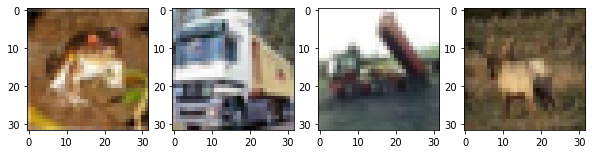

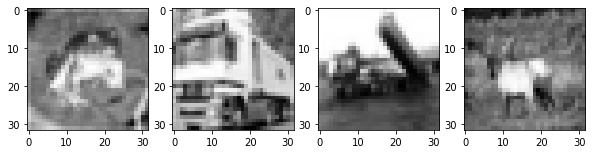

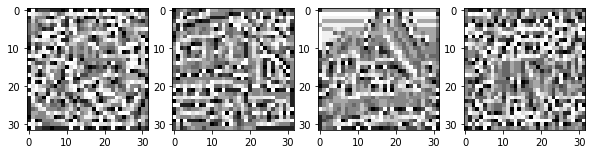

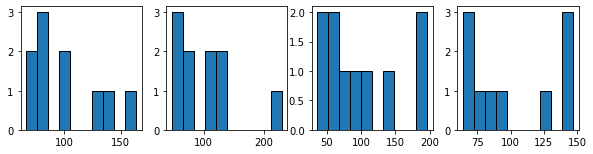

In [26]:
# Sample greyscale converts and LBPs.
print('Grayscale X_tain images:',len(X_train_grayscale_imgs))
print('Grayscale X_test images:',len(X_test_grayscale_imgs))
print('X_train LBPs:',len(X_train_grayscale_lbp))
print('X_test LBPs:',len(X_test_grayscale_lbp))
print('X_tain LBP hist:',len(X_train_grayscale_lbp_hist))
print('X_test LBP hist:',len(X_test_grayscale_lbp_hist))

plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(X_train[i].astype('uint8'))
plt.show()
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(X_train_grayscale_imgs[i],cmap='Greys_r')
plt.show()
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(X_train_grayscale_lbp[i].astype('uint8'),cmap='Greys_r')
plt.show()
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.hist(X_train_grayscale_lbp_hist[i][0],edgecolor='black')
plt.show()

Gather all features (Mean, std, HIS and LBP) into an input array X, and the image classes into an output array y. Standardize the
feature values in X. One standard way of doing it is zscore normalization, meaning that the feature values will have zero mean and unit variance.

In [27]:
# Defining a method to spread everything in 1D arr.
# Parameters are used to define whether the array to be returned is
# train or test array. LBP greyscale histogram is for personal interest
# to see if results change anywhere whether it is used over RGB histograms.
def transform_to_one_dimensional(arr,testdata=False,grayhist=False):
  return_arr = []
  for i in range (len(arr)):
    new_row = []
    new_row_temp = []
    if not testdata:
      if not grayhist:
        new_row_temp.append([X_train_img_mean_color_channels[i].reshape(-1),
                        X_train_img_std_color_channels[i].reshape(-1),
                        X_train_rgb_histograms[i].reshape(-1),
                        X_train_grayscale_lbp[i].reshape(-1)])
      else:
        new_row_temp.append([X_train_img_mean_color_channels[i].reshape(-1),
                        X_train_img_std_color_channels[i].reshape(-1),
                        X_train_grayscale_lbp_hist[i].reshape(-1),
                        X_train_grayscale_lbp[i].reshape(-1)])
    else:
      if not grayhist:
        new_row_temp.append([X_test_img_mean_color_channels[i].reshape(-1),
                        X_test_img_std_color_channels[i].reshape(-1),
                        X_test_rgb_histograms[i].reshape(-1),
                        X_test_grayscale_lbp[i].reshape(-1)])
      else:
        new_row_temp.append([X_test_img_mean_color_channels[i].reshape(-1),
                        X_test_img_std_color_channels[i].reshape(-1),
                        X_test_grayscale_lbp_hist[i].reshape(-1),
                        X_test_grayscale_lbp[i].reshape(-1)])
    new_row_temp = np.asarray(new_row_temp).reshape(-1)
    for j in range(len(new_row_temp)):
      new_row = np.concatenate((new_row,new_row_temp[j]),axis=None)
    return_arr.append(new_row)
  return return_arr

In [28]:
# Defining arrays for X and y, both train and test.
X = []
y = []
X_t = []
y_t = []

# Initializing the scaler for standardizing and fitting with train data.
scaler = StandardScaler()
X = transform_to_one_dimensional(X_train)
X = scaler.fit_transform(X)

# Using the fitted scaler to standardize the test data as well.
X_t = transform_to_one_dimensional(X_test,True)
X_t = scaler.transform(X_t)

# Just for later note. Keeping the labels as numerical for now.
# [0=='plane', 1=='car', 2=='bird', 3=='cat', 4=='deer',
# 5=='dog', 6=='frog', 7=='horse', 8=='ship', 9=='truck']
for cls in y_train:
  y.append(cls)
for cls in y_test:
  y_t.append(cls)

In [29]:
# Quick look at the arrays
print('Length of array X:',len(X))
print('Sample:',X[:4])
print('Length of array y:',len(y))
print('Sample:',y[:4])
print('\nLength of array X_t:',len(X_t))
print('Sample:',X_t[:4])
print('Length of array y_t:',len(y_t))
print('Sample:',y_t[:4])

Length of array X: 50000
Sample: [[ 0.16424544  0.0593338   0.16961638 ... -1.35175683 -0.62639465
  -0.5471645 ]
 [ 0.2495197   0.22255428 -0.16018388 ... -0.97647315 -1.00131513
  -0.5471645 ]
 [ 0.87486428  0.87796677  0.99611984 ... -0.97647315  1.99804873
  -1.17636404]
 [-1.02781766 -0.96490638 -0.83513945 ...  0.52466161  0.12344632
   0.08203504]]
Length of array y: 50000
Sample: [6, 9, 9, 4]

Length of array X_t: 10000
Sample: [[ 0.14825651 -0.23104683 -0.18355029 ...  0.52466161 -1.37623561
   0.08203504]
 [-0.15375649 -0.16778308 -0.06271255 ... -0.22590577 -0.25147416
  -0.5471645 ]
 [-0.49899881 -0.39236941 -0.45193025 ...  0.52466161  0.4983668
  -1.17636404]
 [ 0.52370013  0.61225901  0.71972854 ...  0.52466161 -0.62639465
  -0.5471645 ]]
Length of array y_t: 10000
Sample: [3, 8, 8, 0]


## PCA 
**Question (1 point):** 

Use PCA with 10 component to reduce dimension of the feature vector X.

In [30]:
# Initializing the PCA with 10 components and fitting with train data.
pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)
print('Sample of X after PCA transform:')
print(X[:4])

# Transforming the test data with the same PCA as well.
X_t = pca.transform(X_t)
print('Sample of X_t after PCA transform:')
print(X_t[:4])

Sample of X after PCA transform:
[[ -6.36609714   2.45277867  -4.15630361  -0.51766056   3.7860011
    3.55088525  -5.61989208  -2.59181957   0.41856593   0.24314668]
 [  5.37283363  -5.53699146  -2.08858814  -2.52241525  -6.34475956
    0.76635179  -3.18653727   0.84486451   5.82848331  -0.66643393]
 [  9.71941755 -12.58187717  15.28606146  -3.60397543   7.98561646
   -3.57361326  -1.66633475   5.10737217   4.89620599  -1.69994605]
 [-16.08902066   6.06937216   0.08352517   2.38193491   2.02616452
    2.24911561  -4.29790539  -2.1669776   -0.32661438  -0.89961276]]
Sample of X_t after PCA transform:
[[-4.43931603  0.94248175 -0.25743366  0.92650852 -2.01626889  0.72935622
   0.63454312 -0.89168023  2.16309469 -4.90812555]
 [16.45375779 -7.75038641 11.30738198  0.46725048 -2.23346102 -1.69820196
  -3.96494666 -8.92504949  6.39411575 -2.70056912]
 [ 5.48479478 -2.68058806 11.32964036 -4.57475794 -4.91989044  2.39005046
  -1.6643542   1.23301097  1.4105486   2.07355905]
 [11.70141656  4.

# Build classifiers and estimate their performance

## 1- K-Nearest Neighbor (K-NN) 

In this exercise you will implement a K-NN classifier and understand the basic Image Classification pipeline and  cross-validation.

**Question (2 points):** 

Perform 5-fold cross validation to find the best value of k in range 1 to 30. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times (5),   where in each case you use all but one of the folds as training data and the last fold as a validation set.                   



In [31]:
# Initializing and running through 5-fold cross-validations for
# neighbor counts 1-30. Store the mean scores and present the best in the end.
accuracy = []
for i in range(1,31):
  knn = KNeighborsClassifier(n_neighbors=i)
  cv_score = cross_val_score(knn,X,y,cv=5)
  accuracy.append(np.mean(cv_score))
  print(cv_score)
  print(i,'neighbors cv_scores mean:{}'.format(accuracy[i-1]))
best_neighbors = np.argmax(accuracy,axis=0)+1
print('\nBest score with neighbor amount',best_neighbors)

[0.3113 0.317  0.3153 0.3136 0.3208]
1 neighbors cv_scores mean:0.3156
[0.296  0.2951 0.3028 0.2984 0.2984]
2 neighbors cv_scores mean:0.29813999999999996
[0.3323 0.3245 0.3264 0.3189 0.3266]
3 neighbors cv_scores mean:0.32574000000000003
[0.3487 0.3415 0.3442 0.3416 0.3437]
4 neighbors cv_scores mean:0.34394
[0.3607 0.3503 0.357  0.3492 0.3586]
5 neighbors cv_scores mean:0.35516000000000003
[0.3659 0.3599 0.3691 0.3543 0.3615]
6 neighbors cv_scores mean:0.36214
[0.3749 0.3682 0.373  0.3592 0.3656]
7 neighbors cv_scores mean:0.36818
[0.3729 0.371  0.3779 0.3612 0.3682]
8 neighbors cv_scores mean:0.37024
[0.381  0.3754 0.3795 0.3639 0.3744]
9 neighbors cv_scores mean:0.37484
[0.3798 0.3788 0.3865 0.3717 0.3745]
10 neighbors cv_scores mean:0.37826
[0.3846 0.3763 0.3917 0.3703 0.3783]
11 neighbors cv_scores mean:0.38024
[0.3893 0.3802 0.3928 0.373  0.3791]
12 neighbors cv_scores mean:0.38288
[0.3913 0.3799 0.3942 0.3798 0.3838]
13 neighbors cv_scores mean:0.3858
[0.3928 0.3857 0.3918 0.37

**Question (1 point):** 

- Plot the Cross-validated accuracy based on the different value of k

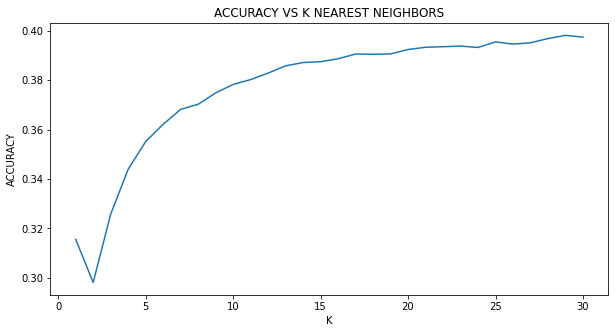

In [32]:
plt.figure(figsize=(10,5))
plt.title('ACCURACY VS K NEAREST NEIGHBORS')
plt.xlabel('K') 
plt.ylabel('ACCURACY')
plt.plot(range(1,31),accuracy)
plt.show()

**Questions (2 points):** 
    
- Based on the cross-validation results above, choose the best value for k,   

- Retrain the classifier using all the training data, and test it on the test data. 

- What is the accuracy value for the test data?

In [33]:
# Fitting KNN classifier with the best observed n value and
# running predictions on test data. Calculating final accuracy.
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X,y)
test_predictions = knn.predict(X_t)
final_acc = metrics.accuracy_score(y_t,test_predictions)
print('Accuracy score for knn with test data',final_acc)

Accuracy score for knn with test data 0.4036


## 2- Logistic Regression (LR)


In this exercise you will implement a LR classifier.

**Question (2 points):** 

- Create and train the Logistic Regression model
- Calculate the accuracy and the confusion matrix on test dataset

In [34]:
lr = LogisticRegression(random_state=1)
lr.fit(X,y)
test_predictions = lr.predict(X_t)
final_acc = metrics.accuracy_score(y_t,test_predictions)
print('Accuracy score for logistic regression with test data',final_acc)
print('\nConfusion matrix:\n',metrics.confusion_matrix(y_t,test_predictions))

Accuracy score for logistic regression with test data 0.3655

Confusion matrix:
 [[469  33  75  15  44  22  25  40 220  57]
 [ 74 244  19  38  35  41  54 110 130 255]
 [ 93  23 278  79 163 123 120  43  34  44]
 [ 39  46 138 150  85 255 102 100  11  74]
 [ 46  29 173  34 374  71 141  65  41  26]
 [ 24  28 125 127  62 395  78  99  22  40]
 [ 16  30 176  76 149  90 358  61   7  37]
 [ 47  46  55  86 116 100  58 333  25 134]
 [155  57  24  15  38  25   3  18 584  81]
 [ 59  87  29  40  26  33  34 104 118 470]]


## 3- Multilayer perceptron 
In this exercise you will develop a neural network with one hidden layer to perform classification.

Use:

- solver for weight optimization: stochastic gradient-based optimizer ('sgd')
- activation function for the hidden layer: rectified linear unit function ('relu')
- Early stop

**Questions (3 points):** 
- What is the prediction accuracy for the test data?
-  To evaluate the MLP model, calculate the metrics such as a confusion matrix, precision, recall, and f1 score. 
-  Show the predicted results (classification lable) on 5 random example of test dataset.
- Show 5 random of wrong predictions

In [35]:
mlp = MLPClassifier(activation='relu',early_stopping=True,solver='sgd',random_state=1)
mlp.fit(X,y)
test_predictions = mlp.predict(X_t)
final_acc = metrics.accuracy_score(y_t,test_predictions)
print('Accuracy score for multilayer perceptron with test data',final_acc)
print('\nPrecision, recall and F1 score:',metrics.classification_report(y_t,test_predictions))
print('\nConfusion matrix:\n',metrics.confusion_matrix(y_t,test_predictions))

Accuracy score for multilayer perceptron with test data 0.4089

Precision, recall and F1 score:               precision    recall  f1-score   support

           0       0.46      0.55      0.50      1000
           1       0.40      0.37      0.38      1000
           2       0.35      0.29      0.32      1000
           3       0.28      0.23      0.26      1000
           4       0.40      0.33      0.36      1000
           5       0.39      0.35      0.37      1000
           6       0.42      0.51      0.46      1000
           7       0.41      0.40      0.40      1000
           8       0.53      0.55      0.54      1000
           9       0.40      0.50      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000


Confusion matrix:
 [[548  42  59  20  30  11  22  26 182  60]
 [ 73 371  16  31  20  29  52  64 109 235]
 [106  54 292 105 100  93 137  57  23  

In [36]:
# Defining a method to convert numerical labels into corresponding string labels.
def show_label_string(int_value):
  if int_value == 0:
    return 'plane'
  elif int_value == 1:
    return 'car'
  elif int_value == 2:
    return 'bird'
  elif int_value == 3:
    return 'cat'
  elif int_value == 4:
    return 'deer'
  elif int_value == 5:
    return 'dog'
  elif int_value == 6:
    return 'frog'
  elif int_value == 7:
    return 'horse'
  elif int_value == 8:
    return 'ship'
  elif int_value == 9:
    return 'truck'

# Gathering a random sample of 5 -- features and predictions of the test set
random_sample = [0]*5
for i in range(len(random_sample)):
  check_index = (random.randint(0,len(test_predictions)-1))
  if check_index not in random_sample:
    random_sample[i] = check_index

# Gathering a random sample of 5 incorrect predictions
random_sample_incorrect = []
random_sample_correct = []
incorrect_pred_features = []
while len(random_sample_incorrect)<5:
  check_index = (random.randint(0,len(test_predictions)-1))
  if check_index not in random_sample_incorrect and test_predictions[check_index] != y_t[check_index]:
    random_sample_incorrect.append(show_label_string(test_predictions[check_index]))
    random_sample_correct.append(show_label_string(y_t[check_index]))
    incorrect_pred_features.append(X_t[check_index])

In [37]:
print('*'*35)
print('Sampling results (5 random)')
print('*'*35)
for i in range(len(random_sample)):
  print('\nTEST FEATURES:',X_t[random_sample[i]],
        '\n--> PREDICTION:',show_label_string(test_predictions[random_sample[i]]))
print('\n')
print('*'*40)
print('Sampling 5 random incorrect predictions')
print('*'*40)
for i in range(len(incorrect_pred_features)):
  print('\nTEST FEATURES:',incorrect_pred_features[i],
        '\n--> INCORRECT PREDICTION:',random_sample_incorrect[i],
        '\n--> CORRECT LABEL:',random_sample_correct[i])

***********************************
Sampling results (5 random)
***********************************

TEST FEATURES: [-14.11522022  -6.13157936  -3.73098118   5.06971193  -2.98654462
  -1.55142421  -4.61566192  -0.36991986  -4.03083094   2.76158573] 
--> PREDICTION: bird

TEST FEATURES: [-1.62840822 10.30790294  0.03767868  0.94964003  2.82226674  1.27740781
  0.76477755  0.19457101 -2.34538942 -0.91627325] 
--> PREDICTION: deer

TEST FEATURES: [ 5.53755288  1.11262046 -8.75472089 -7.81372113 -2.45512404  3.52055012
 -3.67504853  3.59909678  4.11392845  0.0686976 ] 
--> PREDICTION: dog

TEST FEATURES: [-3.87043958  2.8111149   8.94710865 -0.97100731 -1.54997218 -2.62441686
  0.20217532 -0.1662208  -0.66771007 -0.54378468] 
--> PREDICTION: ship

TEST FEATURES: [-0.30140414 -5.85629399 -8.73486431 -1.36265148 -0.52561504 -1.80858065
 -0.89957656 -7.13843303 -0.13390345 -4.12386458] 
--> PREDICTION: dog


****************************************
Sampling 5 random incorrect predictions
****